# End-to-end Multi-Class Dog Breed Classification

This notebooks builds an end-to-end multiclass image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.


## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data




In [0]:
# Unzipping the data files into Google Drive!
#!unzip "/content/drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog Vision/"

## 3. Evaluation

We will evaluate our model by the metric *multiclass log loss*, ie. the prediction probabilities of each dog breed for each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (so 120 classes).
* There are 10k+ images in the training set (with labels).
* There are 10k+ images in the test set (no labels).

## Getting out workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub (from which is where we will pick our model)
* Make sure we're using a GPU

In [78]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.2.0


In [79]:
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

TF Hub version: 0.8.0


In [80]:
# Check for GPU availability
print("GPU", "available (YES!!!)" if tf.config.list_physical_devices("GPU") else "not available :(" )

# If we're not using a GPU,
  # go to Runtime > Change runtime type
  # set GPU and save

GPU available (YES!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representation).

**Loading labels**

Let's start by accessing our data and checking out the labels. This file contains the ID/name of each image in the training set and the corresponding dog breed!

In [81]:
import pandas as pd

# Loading our data labels
labels_csv = pd.read_csv("/content/drive/My Drive/Dog Vision/labels.csv")
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     e23950a981b81588f00133a2c0c5cfb7  scottish_deerhound
freq                                   1                 126

In [82]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [83]:
labels_csv.breed.value_counts().median()

82.0

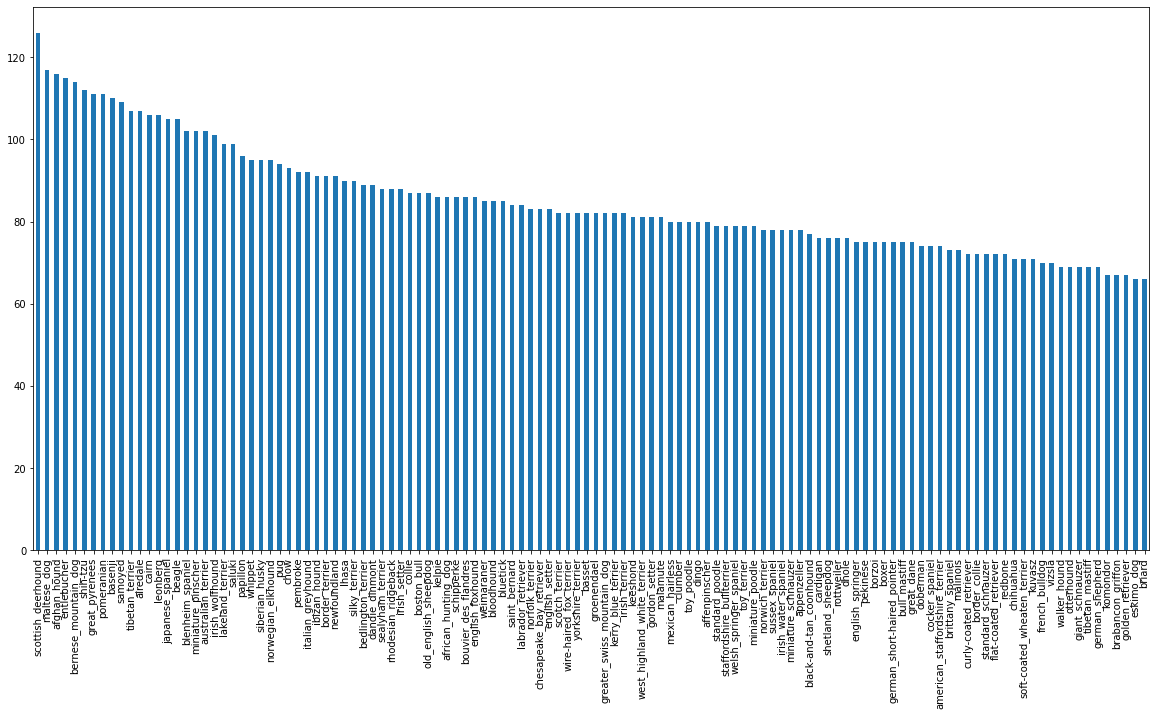

In [84]:
# How many images are there of each breed?
labels_csv.breed.value_counts().plot.bar(figsize=(20,10));

It is recommended that we have at least 10 images per dog breed, which we definitely do!

https://cloud.google.com/vision/automl/object-detection/docs/prepare

**Preparing training images pathnames**

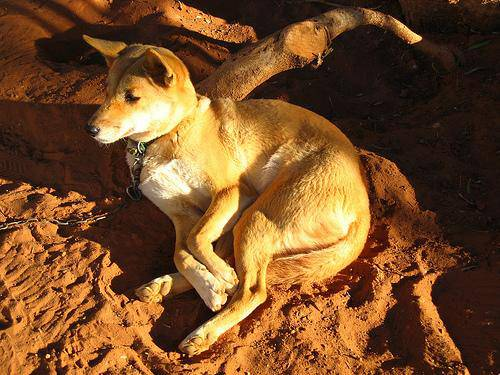

In [85]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [86]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg"
             for fname in labels_csv["id"]]
filenames

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'drive/My Drive/Dog Vision/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'drive/My Drive/Dog Vision/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'drive/My Drive/Dog Vision/train/00693b8bc2470375cc744a6391d397ec.jpg',
 'drive/My Drive/Dog Vision/train/006cc3ddb9dc1bd82

In [87]:
# Checking nr pathnames = nr image files in training set
import os
if len(os.listdir("drive/My Drive/Dog Vision/train")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames don't match the actual amount of files!!! Stop!")

Filenames match actual amount of files!!! Proceed.


**Preparing dog breeds (labels)**

Since we've got our training image filepaths in a list, let's prepare our labels.

In [88]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [89]:
len(labels)

10222

In [90]:
# Check if nr labels = nr filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, so check data directories!")

Number of labels matches number of filenames!


In [91]:
# Find unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [92]:
len(unique_breeds)
  # 120 breeds of dogs

120

In [93]:
# Turning a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

# we get true only in the 20th position
# and if we check unique_breeds the 20th position is in fact boston_bull

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [94]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [95]:
# Convert boolean arrays into numbers
boolean_labels = [label.astype(int) for label in boolean_labels]
boolean_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Creating our own validation set:

Since the dataset from Kaggle does not provide a cross-validation set, we will create our own!

In [0]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [1]:
# Set slider for nr images to use
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [98]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

So we have 800 samples in the training set and 200 in the validation set.

### Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input;
2. Use TensorFlow to read the file and save it to a variable, `image`;
3. Turn our `image` (a jpg) into Tensors;
4. Normalize our image: convert color channel values from 0-255 to 0-1);
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

https://www.tensorflow.org/guide/data
https://www.tensorflow.org/tutorials/load_data/images

Let's start with an example with one image.

In [99]:
# Convert an image to NumPy array
from matplotlib.pyplot import imread
  # imread: image read

image = imread(filenames[42])
image.shape
  # (height, width, 3)
  # 3 stands color channels (red, green, blue)

(257, 350, 3)

In [100]:
image.max(), image.min()

(255, 0)

In [101]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [102]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

We get exactly the same thing, but the second is now a Tensor, which will run in TensorFlow much faster!

Now let's do the steps above:

In [0]:
# Create a function for preprocessing images

IMG_SIZE = 224

def process_image(image_path):
  """Takes an image file path and turns the image into a Tensor."""

  # Read in image file
  image = tf.io.read_file(image_path)
    # io stands for input/output

  # Turn our image into numerical tensor with 3 color channels
  image = tf.image.decode_jpeg(image, channels=3)
    # returns a Tensor object
  
  # Normalization:
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize image to our desired value (244, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

### Turning our data into batches

Let's say you're trying to process 10k+ images in one go... they all might not fit into memory. So we split our data into batches of about 32 images.

https://twitter.com/ylecun/status/989610208497360896

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which looks like this: `(image, label)`.



In [0]:
# Create a simple function to returns a tuple (image, label) of tensors

def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image=process_image(image_path)
  return image, label

In [105]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form `(image, label)`, let's make a function to turn all of our data (`X` and `y`) into batches!

In [0]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle it it's validation data.
  Also accepts test data as input (no labels).
  """

  # test data
  if test_data:
    print("Creating test data batches...")
    # Creates a tensorflow dataset from the tensors slices
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))

    # Creates a data batch of size BATCH_SIZE
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # validation data
  if valid_data:
    print("Creating validation data batches...")
    # Creates a tensorflow dataset from the tensors slices
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                               tf.constant(y))) # labels

    # Creates a data batch of size BATCH_SIZE
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        # Note: here we also process the images
    return data_batch

  # training data
  else:
    print("Creating training data batches...")
    # Creates a tensorflow dataset from the tensors slices
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                               tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor fn
    # (because it's faster)
    data = data.shuffle(buffer_size=len(X))

    # Creates a data batch of size BATCH_SIZE
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
          # Note: here we also process the images
    return data_batch


In [107]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [108]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec
  # shape=(None, 224, 224, 3) is an image
    # None: batch size
  # shape=(None, 120) is a label

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)))

## Visualizing Data Batches

Our data is now in batches. However, these can be a little hard to understand, so let's visualize them.

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels, from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))

  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 cols)
    ax = plt.subplot(5, 5, i+1)

    # Display an image
    plt.imshow(images[i])

    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    # Turn the grid lines off (cleaner plot)
    plt.axis("off")

In [110]:
# In order to visualize a batch, we need to un-batch it!
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[4.17550802e-01, 4.21472371e-01, 3.90099823e-01],
          [4.38528955e-01, 4.42450523e-01, 4.18921113e-01],
          [4.35618013e-01, 4.39539582e-01, 4.16325301e-01],
          ...,
          [6.62377104e-02, 8.12937692e-02, 8.45851228e-02],
          [9.40126106e-02, 1.10294163e-01, 1.04586780e-01],
          [9.40126106e-02, 1.13620460e-01, 9.79341865e-02]],
 
         [[4.26243037e-01, 4.30164605e-01, 3.98792058e-01],
          [4.47671592e-01, 4.51593161e-01, 4.28063750e-01],
          [4.44310248e-01, 4.48231816e-01, 4.25017536e-01],
          ...,
          [8.32672045e-02, 9.87832695e-02, 1.02534629e-01],
          [9.72951725e-02, 1.18867017e-01, 1.10731736e-01],
          [9.72951725e-02, 1.19765416e-01, 1.04079142e-01]],
 
         [[4.26989198e-01, 4.30910766e-01, 3.99538219e-01],
          [4.45019275e-01, 4.48940843e-01, 4.25411433e-01],
          [4.45579499e-01, 4.49501067e-01, 4.26286787e-01],
          ...,
          [9.89565402e-02, 1.15423679e-01, 1.2090

In [111]:
len(train_images), len(train_labels)

(32, 32)

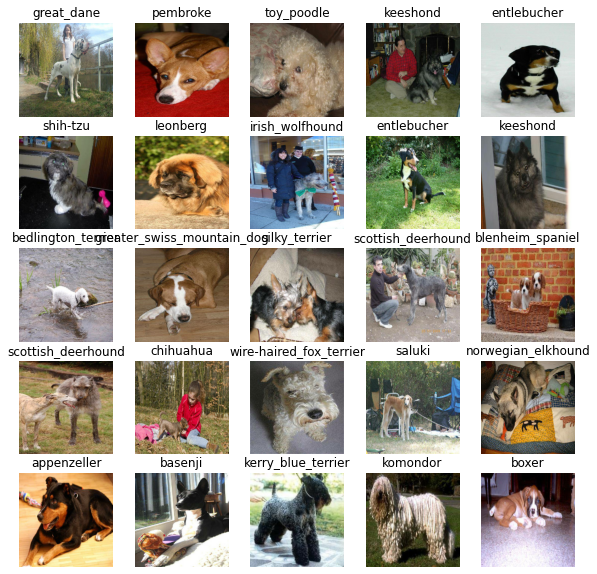

In [112]:
# Visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

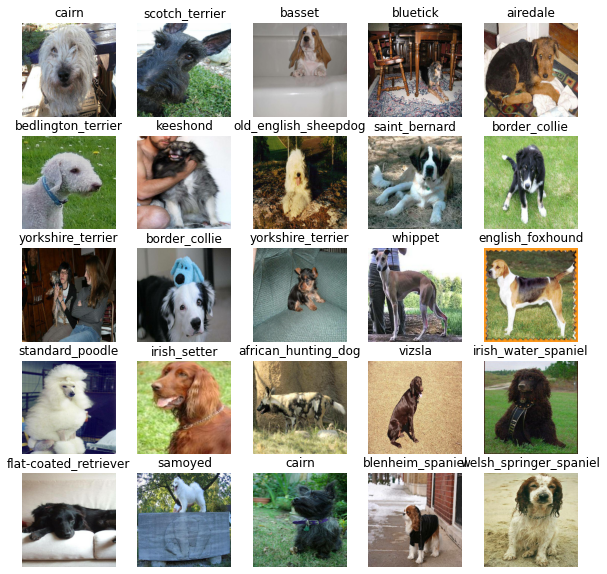

In [113]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our image shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) to our model.
* The URL of the model we want to use.

Upon searching in TensorFlow Hub, we have decided to choose the model in: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4.

This model, MobileNet_V2, is a **convolutional neural network**. Check more here:
* https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c.
* https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53



In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
  # batch, height, width, colour channels

# Setup output shape
OUTPUT_SHAPE = len(unique_breeds)
  # 120

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
  # Copied from the TensorFlow Hub page above.

Now we've got our inputs, outputs and model ready to go, let's put them together into a Keras deep learning model!

Knowing this let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a **Keras** model in sequential fashion (do this first, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here:
* https://www.tensorflow.org/guide/keras
* https://www.tensorflow.org/guide/keras/overview

In [0]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  """
  This function builds a Keras model.
  """
  
  print("Building model with:", MODEL_URL)

  # Setup the model layers (as in a Neural Network)
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax") # Layer 2 (output layer)
  ])

  # Very similar to instructions here:
  # https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

  # By default, the output layer of this model has 1280 units
    # see overall architecture here:
    # https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c
  # so we specify that we only want OUTPUT_SHAPE units!

  # We use "softmax" because the results is a vector:
    # every component is a number between 0 and 1
    # the components add up to 1
  # Check: https://en.wikipedia.org/wiki/Softmax_function

  # In general:
    # For binary classification
      # activation = "sigmoid"
      # loss = binary crossentropy
    # For multiclass classification
      # activation = "softmax" (as above)
      # loss = categorical crossentropy (as below)
  

  # Compile the model (~"putting the model together")
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # loss: a measure of how well the model is guessing
    # we want to MINIMIZE loss
  # https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/


  # optimizer: helps how to minimize loss
  # The Adam optimizer performs well on most models!
    # https://www.google.com/search?q=adam+optimization&oq=adam+optimization&aqs=chrome..69i57j0l7.3511j0j4&sourceid=chrome&ie=UTF-8
  # Others:
    # RMS prop
    # Stochastic gradient descent
  
  # metrics: a measure of evaluating those guesses
  # https://www.tensorflow.org/api_docs/python/tf/keras/metrics


  # Build the model
  model.build(INPUT_SHAPE)
  # as instructed here:
  # https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

  return model

In [116]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_4 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


This model, MobileNet_V2, has trained in a data set from Imagenet, which is a database of images.
* Check Training in: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
* http://www.image-net.org/

The model has learned 5,432,713 parameters/patterns, and we're using them in our own problem, where we're trying to learn 120,240 patterns.


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progres or stop training early if a model stops improving.

https://www.tensorflow.org/guide/keras/custom_callback

We'll create two callbacks,:
* one for TensorBoard which helps track our models' progress,
* and another for early stopping which prevents our model from training for too long (potentially preventing overfitting).

### TensorBoard callback

To set up a TensorBoard callback, we need to things 3 things:
1. Load the TensorBoard notebook extension;
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit` function.
3. Visualize our model's training logs with the `%tensorboard` magic function (we'll do this after model training).


https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [117]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
import datetime
# to access the current date & time

# Create a funciton to build a TensorBoard callback
def create_tensorboard_callback():

  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment.
                        # The name of the log file will be the date when the experiment is run
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Callback for early stopping

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
 # Create early stopping callback

 early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                   patience=3)
 # monitors: evaluation metric for checking model's improvement
 # patience: nr epochs with no improvement after which training will be stopped
    # what are epochs?

## Training our Deep Neural Network

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [121]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YES!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YES!!!)


Let's create a function which trains a model:

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return a model.

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # Create a model
  model = create_model()

  # Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
              # how often we want to test on the validation data
              # the patterns found in training data
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model
  return model

In [123]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 2/25 [=>............................] - ETA: 8s - loss: 5.6709 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.334009). Check your callbacks.


25/25 [==============================] - 6s 223ms/step - loss: 4.5457 - accuracy: 0.1200 - val_loss: 3.4101 - val_accuracy: 0.2850
Epoch 2/100
25/25 [==============================] - 5s 189ms/step - loss: 1.6252 - accuracy: 0.6775 - val_loss: 2.1767 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 5s 194ms/step - loss: 0.5642 - accuracy: 0.9312 - val_loss: 1.6805 - val_accuracy: 0.6500
Epoch 4/100
25/25 [==============================] - 5s 192ms/step - loss: 0.2496 - accuracy: 0.9887 - val_loss: 1.5136 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 5s 192ms/step - loss: 0.1447 - accuracy: 0.9975 - val_loss: 1.4296 - val_accuracy: 0.6550
Epoch 6/100
25/25 [==============================] - 5s 193ms/step - loss: 0.0999 - accuracy: 0.9987 - val_loss: 1.3834 - val_accuracy: 0.6700
Epoch 7/100
25/25 [==============================] - 5s 190ms/step - loss: 0.0744 - accuracy: 1.0000 - val_loss: 1.3528 - val_accuracy: 0.6800
Epoch 8/100

It looks like our model is overfitting because it's performing far better on the training dataset (accuracy=100%) than on the validation dataset (accuracy~66%).

**Question:** What are some ways to prevent our model from overfitting in deep learning neural networks?

## Evaluating Performance with TensorBoard

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created ealier and visualize its contents. More specifically it plots the evolution of accuracy and loss throughout the epochs!

In [124]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

Output hidden; open in https://colab.research.google.com to view.

## Making and evaluating predictions using a trained model

In [125]:
# Make prediction os the validation data (not used to train on)
predictions = model.predict(val_data,
                            verbose=1)
  # verbose=1: show progress
predictions

7/7 [==============================] - 1s 126ms/step


array([[9.23160277e-03, 4.33731220e-05, 2.59149150e-04, ...,
        5.63009467e-04, 2.35442549e-05, 3.02490150e-03],
       [1.41621684e-03, 7.20989192e-04, 1.14710815e-02, ...,
        7.96234352e-04, 1.25111337e-03, 2.13275984e-04],
       [8.34603907e-06, 1.59317628e-04, 2.55872554e-04, ...,
        1.37022407e-05, 5.25455507e-05, 1.64142912e-04],
       ...,
       [3.12226766e-05, 1.73488181e-04, 2.22887847e-05, ...,
        4.04997736e-05, 2.92325945e-04, 8.25120194e-04],
       [1.99341751e-03, 3.75099306e-04, 1.61935914e-05, ...,
        5.95255588e-05, 8.20163405e-05, 9.81161278e-03],
       [1.80244946e-03, 2.08408746e-05, 9.50378599e-04, ...,
        6.92338264e-03, 3.22765118e-04, 4.41028424e-05]], dtype=float32)

In [126]:
predictions.shape
  # validation data size: 200
  # nr breeds: 120

(200, 120)

In [127]:
predictions[0]

array([9.2316028e-03, 4.3373122e-05, 2.5914915e-04, 4.4524910e-05,
       6.7231792e-04, 6.2787018e-05, 1.8735314e-02, 8.9742978e-05,
       7.2121900e-04, 1.0314643e-03, 1.2280698e-03, 1.1795187e-04,
       4.5106094e-04, 7.1116141e-04, 6.2266216e-03, 6.1759674e-05,
       2.0784629e-04, 6.4346239e-02, 1.1064344e-04, 7.3766583e-05,
       6.2085921e-04, 8.5466585e-05, 9.4592695e-05, 1.1483810e-03,
       1.0196063e-04, 1.1710944e-04, 4.1497511e-01, 4.3692920e-04,
       1.3257785e-03, 1.5480422e-03, 2.1172619e-04, 5.7720388e-03,
       5.5148831e-04, 6.4481581e-05, 4.0496303e-05, 3.2401424e-02,
       1.2417604e-05, 1.0351751e-03, 6.0735678e-04, 2.3347614e-04,
       6.6769501e-04, 1.2267359e-04, 3.1386637e-05, 1.3220709e-04,
       3.7467496e-05, 1.8733105e-04, 8.1452945e-06, 1.5544337e-04,
       3.8134784e-04, 2.9308314e-04, 3.4230074e-05, 1.3713355e-04,
       1.1584838e-03, 2.2128351e-04, 7.4806792e-04, 7.2283125e-05,
       6.1141496e-04, 1.1903655e-02, 2.4217552e-04, 3.1186135e

For each image we get a vector of size 120, which contains the probability that that picture corresponds to each of the 120 dog breeds. The highest value in this vector will be the dog breed the model will assign to this picture.

* This is why we used activation="softmax" in `create_model` function. We can check that this probability vector adds up to (very close to) 1.

In [128]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[4.23503989e-05 4.00849312e-05 5.12504848e-05 3.07565824e-05
 9.37429024e-04 8.88694776e-05 5.61323468e-05 8.37460626e-04
 3.28655005e-03 1.70083195e-02 8.23190057e-05 3.66123459e-06
 1.38354735e-05 2.81463610e-03 2.05327902e-04 1.06318516e-03
 5.19526429e-06 1.50442167e-04 4.42770164e-04 1.39739714e-04
 4.12847330e-05 9.31629256e-05 2.85913156e-05 9.47773697e-06
 1.10448860e-02 7.69449689e-05 9.65739528e-05 2.59987137e-04
 1.01055964e-04 2.40296449e-05 1.73252938e-05 7.00766323e-05
 8.48978380e-05 1.53435067e-05 1.34299131e-04 2.50649700e-05
 2.66704301e-04 3.86621796e-05 1.36107419e-05 2.11578026e-01
 5.01986178e-05 1.44385176e-05 5.59089007e-04 3.52999223e-06
 2.08773083e-04 3.90458335e-05 8.95801568e-05 2.30218779e-04
 1.44530786e-05 1.78219037e-04 7.66562789e-06 7.69948092e-05
 3.51322728e-04 1.10143295e-03 1.58865660e-05 1.70678948e-04
 9.38705125e-05 5.06276083e-05 9.03234759e-05 4.11496694e-05
 1.18170945e-04 2.70360353e-04 1.97434588e-06 1.28282600e-05
 5.50178884e-05 5.201374

## Transform predictions to text

Having the above functionality is great but we want to be able to do it at scale. And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [129]:
# Turn probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (true labels).

In [0]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, labels) Tensors
  and returns separate arrays of images and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

In [131]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

## Visualize and evaluate model predictions

Now we've got ways to get:
* Prediction labels;
* Validation labels (truth labels);
* Validation images.

Let's make some function to make all these a bit more easy to visualize. We'll create a function which:
* Takes an array of prediction probabilities, an array of truth lavels, an array of images and an integer.
* Converts the prediction probabilities to a predicted label.
* Plots the predicted label, its predicted probability, the true label and the target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and imge for sample n
  """

  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Plot title
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob*100),
                                    true_label),
            color=color)

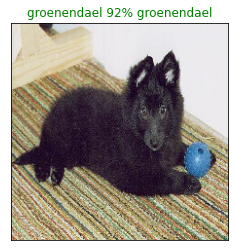

In [133]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got a function to visualize our model's predictions, let's make another to view our model's top 10 predictions on a single image. This function will:

* Take an input of prediction probabilities array, a ground truth array and an integer.
* Find the prediction using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [0]:
# Visualize top 10 predictions for a specific images
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # ar.argsort() gives the order of indexes
      # that will sort the array ar in increasing order
    # [-10:] top 10 prediction indexes but still in increasing order
    # [::-1] changes to decreasing order

  # Top 10 prediction probabilities
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

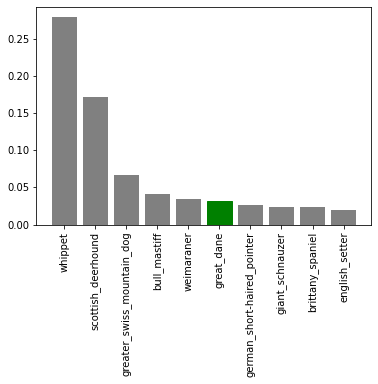

In [135]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=99)

Now we've got some functions to help us visualize our predictions and evaluate our model, let's check them out.

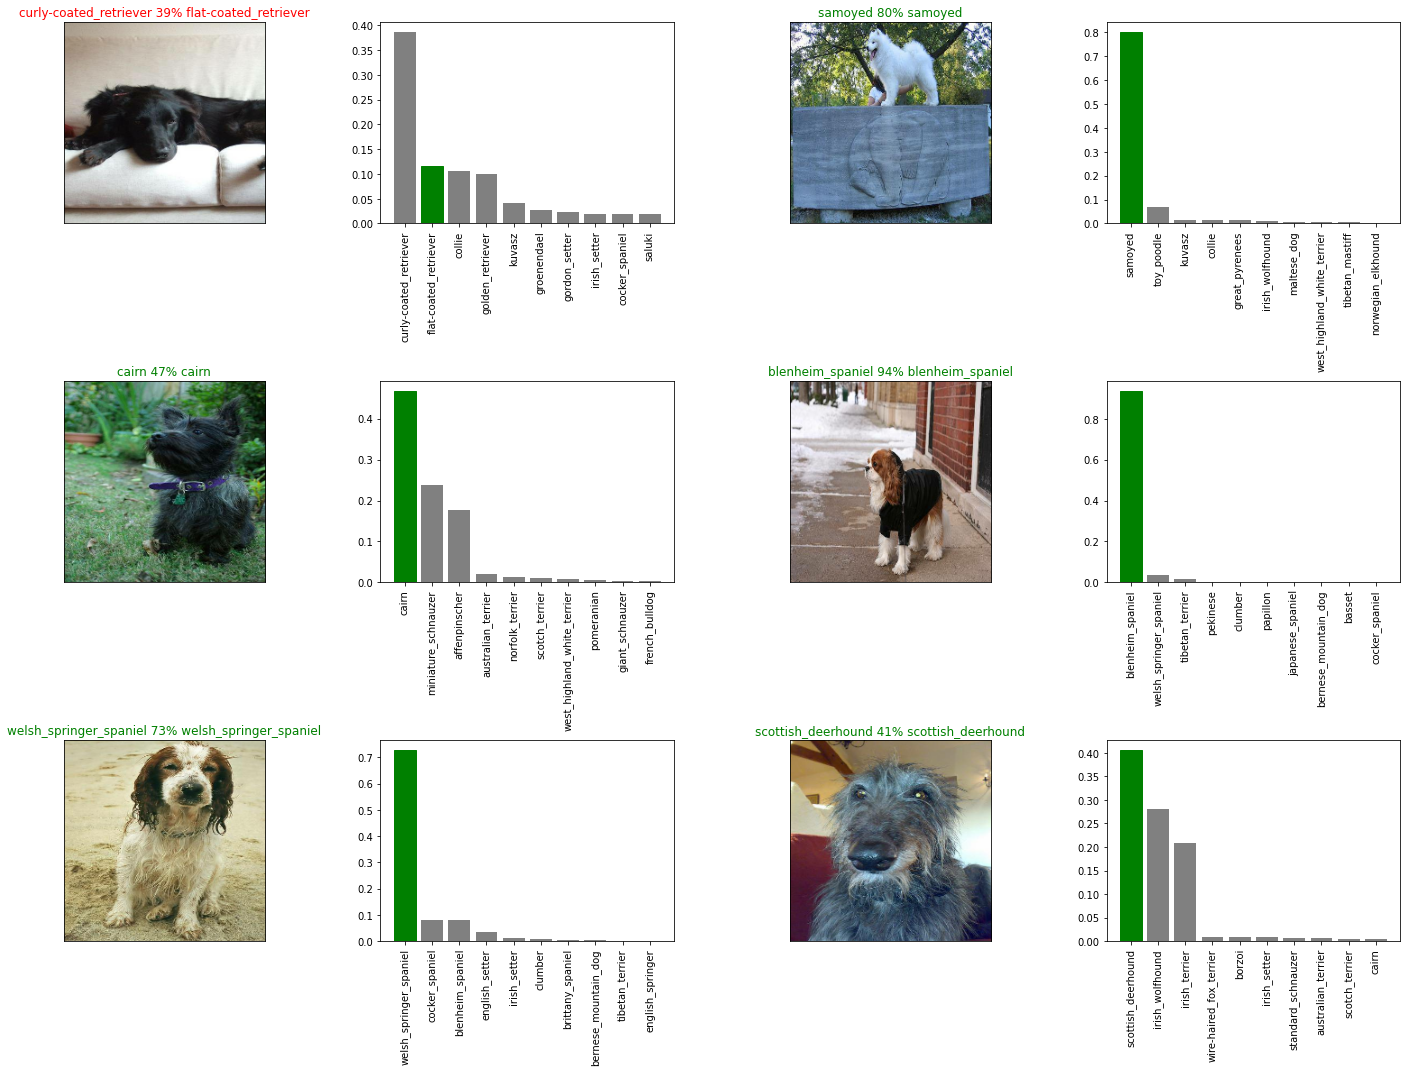

In [136]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  # images
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  
  # graphs
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0) # make plot better!
plt.show()

**Challenge:** create a confusion matrix with our model's predictions and true labels.

## Saving and reloading a trained model

We'll create a function for doing this!


https://www.tensorflow.org/tutorials/keras/save_and_load


In [0]:
# Create a function for saving a model

def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5"  # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [0]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """

  print(f"Loading saved model from: {model_path}")

  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
    # custom_objects=... is to tell the loading function that we have 
    # a KerasLayer that it is not expecting
    # (see create_model function, where we created it)

  return model

Let's make sure they work:

In [139]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200616-122645-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200616-122645-1000-images-mobilenetv2-Adam.h5'

In [140]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20200616-102029-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200616-102029-1000-images-mobilenetv2-Adam.h5


Sometimes, we can get warnings here related to saving the state of the optimizer. These can be ignored.

In [141]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 116ms/step - loss: 1.3044 - accuracy: 0.6650


[1.3044440746307373, 0.6650000214576721]

In [142]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 115ms/step - loss: 1.2152 - accuracy: 0.6600


[1.2151806354522705, 0.6600000262260437]

As we can see, we obtain the same thing, meaning that the model was saved and loaded correctly.

## Training our model in the whole dataset

In [143]:
# X: all training features
# y: all training labels

len(X), len(y), len(X_train)
# total training examples: 10222
# nr training example we've been using: 800

(10222, 10222, 800)

In [144]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)
full_data

Creating training data batches...


<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.int32)>

In [145]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy

full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load al of the images into memory.

In [147]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 4399s 14s/step - loss: 1.3332 - accuracy: 0.6730
Epoch 2/100
320/320 [==============================] - 49s 153ms/step - loss: 0.4000 - accuracy: 0.8817
Epoch 3/100
320/320 [==============================] - 49s 152ms/step - loss: 0.2393 - accuracy: 0.9339
Epoch 4/100
320/320 [==============================] - 47s 148ms/step - loss: 0.1512 - accuracy: 0.9646
Epoch 5/100
320/320 [==============================] - 47s 147ms/step - loss: 0.1049 - accuracy: 0.9777
Epoch 6/100
320/320 [==============================] - 46s 144ms/step - loss: 0.0782 - accuracy: 0.9860
Epoch 7/100
320/320 [==============================] - 46s 145ms/step - loss: 0.0589 - accuracy: 0.9916
Epoch 8/100
320/320 [==============================] - 46s 143ms/step - loss: 0.0463 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 45s 142ms/step - loss: 0.0376 - accuracy: 0.9965
Epoch 10/100
320/320 [==============================] - 46s 145m

In [148]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200616-135515-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200616-135515-full-image-set-mobilenetv2-Adam.h5'

In [149]:
# Loading the full model
loaded_full_model = load_model('drive/My Drive/Dog Vision/models/20200616-135515-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200616-135515-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions of the test set we'll have to get it into the same format.

Tasks:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the parameter `test_data=True`.
* Make a predictions arrays by passing the test batches to the `predict()` method called on our model.

In [158]:
# Load test image filenames
test_path = '/content/drive/My Drive/Dog Vision/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
len(test_filenames)

10357

In [159]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)
test_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about 1h)!

In [160]:
# Make predictions on test data with loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 5160s 16s/step


In [0]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [0]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

### Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our model's prediction probability outputs in a dataframe with an ID column and a column for each different dog breed.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a Pandas dataframe with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the dataframe as a CSV file to submit to Kaggle.

In [0]:
# Create a Pandas dataframe with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))

In [0]:
# Append test image ID's to predictions dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [165]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  f30e9a91acfb7e0fd1a3f9b91ca36914  ...       4.24073e-09
1  ec429df7ceab9763e4e790b569997346  ...       8.82747e-09
2  e9b16b4bdf5b0561fc7c69b2f36e1a7e  ...        1.2642e-12
3  f4b31ede23331910d4f15664be4db5d3  ...       1.25873e-14
4  f14672c3ea8086560de6b7e79f9b90d1  ...       2.25046e-10

[5 rows x 121 columns]

In [0]:
# Export dataframe to CSV file
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

I submitted this on Kaggle as a late submission, and obtained score of 0.934.

## Making predictions on our own images

To make predictions on our own images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [174]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/IMG_1026.JPG',
 'drive/My Drive/Dog Vision/my-dog-photos/95952cc5-9e14-40f8-a448-bda1006dbee9.JPG',
 'drive/My Drive/Dog Vision/my-dog-photos/IMG_5396.JPG']

In [175]:
# Turn custom images into data batches
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [178]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds.shape
  # 3 objects of size 120 (= nr unique breeds)

(3, 120)

In [179]:
# Get the custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['dingo', 'redbone', 'chesapeake_bay_retriever']

In [182]:
# Get custom images
# PS. Our unbatchify() function won't work since there aren't labels!
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)
custom_images

[array([[[0.74065626, 0.56810725, 0.42468992],
         [0.7314226 , 0.56671673, 0.40201083],
         [0.74559325, 0.5769658 , 0.41225994],
         ...,
         [0.9581083 , 0.9003352 , 0.8176321 ],
         [0.9471849 , 0.8883614 , 0.8103499 ],
         [0.9535125 , 0.89468896, 0.81163573]],
 
        [[0.67710084, 0.5107143 , 0.3642157 ],
         [0.7602391 , 0.5884404 , 0.43512407],
         [0.76611155, 0.59748405, 0.43277815],
         ...,
         [0.9190877 , 0.85242105, 0.7818328 ],
         [0.94729894, 0.8884754 , 0.8119146 ],
         [0.9508404 , 0.8920169 , 0.8113147 ]],
 
        [[0.64107144, 0.472444  , 0.33911064],
         [0.7562426 , 0.58482397, 0.41934276],
         [0.769818  , 0.59726894, 0.44432777],
         ...,
         [0.97174937, 0.9050827 , 0.8344945 ],
         [0.9344588 , 0.8717137 , 0.7780162 ],
         [0.9356841 , 0.872939  , 0.7783114 ]],
 
        ...,
 
        [[0.5719447 , 0.5101755 , 0.48008904],
         [0.57605654, 0.517233  , 0.49762

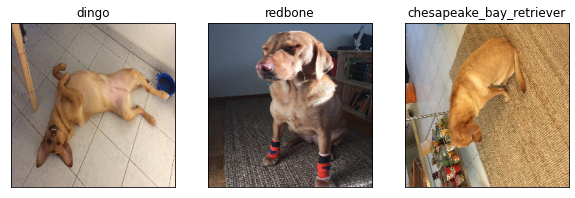

In [184]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

And we're done! We've built our model for predicting a dog breed from a picture! :D